<a href="https://colab.research.google.com/github/bmijangos/ProyectoIntegrador/blob/main/Avance4_Equipo21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Tecnológico de Monterrey**

# **Proyecto Integrador**
## Avance 4
## Modelos alternativos
###Dra. Grettel Barceló Alonso
###EQUIPO 21
###Bernardo Mijango Flores - A01793654
###Dalia Isabel López Tapia - A01245026
###David Valles Canedo - A01191310
26 de mayo de 2024

# Importaciones, Funciones, Dependencias y Pasos Iniciales

In [2]:
# conectamos al drive de google para la lectura de los archivos csv
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns   # para un mejor despliegue de los gráficos

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score  # Importar accuracy_score desde sklearn.metrics

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

#Las siguientes librerías son los modelos que voy a entrenar y el método de validación cruzada k-fold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree  # para el grafico de arbol de decision
from IPython.display import Image

import scipy.cluster.hierarchy as sch   # requerimos el módulo referente a la agrupamiento jerárquico.
from sklearn.cluster import AgglomerativeClustering    # usaremos la técnica de agrupamiento llamada aglomerativa


In [ ]:
# función para mostrar un diagrama de caja encima de un histograma
def plot_boxplot_hist(data, variable):
  f,(ax_box, ax_hist) = plt.subplots(2,
                                     sharex=True,
                                     gridspec_kw={"height_ratios":(0.50,0.85)})
  sns.boxplot(x=data[variable],ax=ax_box)
  sns.histplot(data=data, x=variable, ax=ax_hist)
  ax_box.set(xlabel="")
  plt.title(variable)
  plt.show()


In [3]:
# función para encontrar los límites de una distribución variable usando la regla de proximidad del rango intercuartil:

def find_limits(df,variable,fold):
  IQR = df[variable].quantile(0.75)-df[variable].quantile(0.25)
  lower_limit = df[variable].quantile(0.25)-(IQR * fold)
  upper_limit = df[variable].quantile(0.75)+(IQR * fold)
  return lower_limit, upper_limit

In [4]:
def get_models():

    models = list()
    names = list()

    # LR - Regresión Logística:
    models.append(LogisticRegression(solver='liblinear'))
    names.append('Logistic Regression')

    # DT - Árbol de Decisión:
    models.append(DecisionTreeClassifier())
    names.append('Decision Tree')

    # RFC - Random forest classifier
    models.append(RandomForestClassifier())
    names.append('Random Forest Classifier')

    return models, names

In [5]:
def mi_accuracy (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_accuracy = (VP + VN) / (VP + VN + FP + FN)
  return mi_accuracy

def mi_precision (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_precision = VP / (VP + FP)
  return mi_precision

def mi_recall (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_recall = VP / (VP + FN)
  return mi_recall

def mi_f1_score (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_f1_score = (2*VP) / (2*VP + FP + FN)
  return mi_f1_score

def mi_G_mean (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_G_mean = np.sqrt((VP / (VP + FN))*(VN / (VN + FP)))
  return mi_G_mean

In [6]:
def plot_roc(fpr_svc, tpr_svc, roc_auc_svc):
  plt.figure()
  plt.plot(fpr_svc, tpr_svc, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

In [7]:
def calculate_print_metrics(model, y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, pos_label='CAN')
  recall = recall_score(y_test, y_pred, pos_label='CAN')
  f1 = f1_score(y_test, y_pred, pos_label='CAN')
  confusion_matrixs = confusion_matrix(y_test, y_pred)

  print(model)
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-Score:", f1)
  print("Confusion Matrix:\n", confusion_matrixs)

# Lectura de los datos

Se realizo una corrección en la consulta de la base de datos para obtener la edad del cliente al momento del desembolso del crédito, en el avance 1 nos dimos cuenta de este error, además se agregaron los castigos en el mismo archivo dando un total de 4,382,214 registros resultado de los 4,254,537 del archivo de pagos mas 127,677 del archivo de castigos

In [5]:
# Lectura de los archivos csv
file_path = '/content/drive/MyDrive/DataSetProyecto/GrupalTodoCorregido.csv'

label = ["IdCliente","FechaAltaCliente","CodigoGrupo","EdadCliente","Genero","EstadoCivil","Escolaridad","CapacidadPago","Localidad","CodigoSucursal","CodigoASesor","NumeroCredito","CicloCliente","FechaDesembolso","FechaVencimiento","FechaCancelacion","Plazo","PeriodoPago","EstatusCredito","MontoCredito","CuotaNumero","CuotaFechaVencimiento","CuotaFechaCancelacion","MontoCuota","MontoCapital","SaldoCapital","EstatusCuota","DiasAtraso"]

# Obtenemos el dataframe
grupal_df = pd.read_csv(file_path, names=label)

grupal_df.shape

(4382214, 28)

Text(0.5, 1.0, 'Proporcion de datos faltantes por variable')

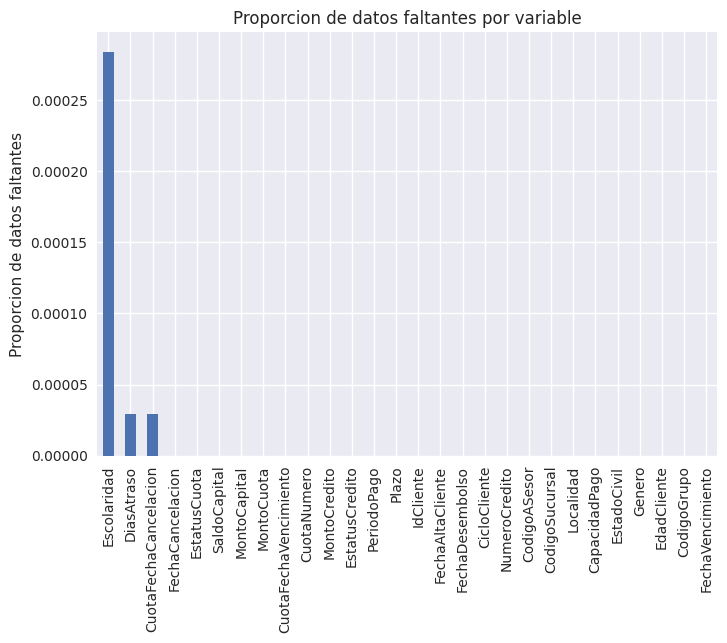

In [6]:
# visualizamos la proporcion de los datos faltantes

with plt.style.context("seaborn"):
  grupal_df.isnull().mean().sort_values(ascending=False).plot.bar(rot=90)

plt.ylabel("Proporcion de datos faltantes")
plt.title("Proporcion de datos faltantes por variable")


Al ser un procentaje menor al 0.028 % se decide eliminarlos de la muestra

In [7]:
# eliminamos los valores nulos
gpdf = grupal_df.dropna()

In [8]:
gpdf.isnull().values.any()

False

In [9]:
# Reemplazamos los valores negativos de la variable DiasAtraso por 0 ya que son pagos anticipados
gpdf.loc[gpdf['DiasAtraso'] < 1,'DiasAtraso'] = 0


In [10]:
print(gpdf.describe(exclude=[object]))

          IdCliente   CodigoGrupo   EdadCliente   EstadoCivil  CapacidadPago  \
count  4.380844e+06  4.380844e+06  4.380844e+06  4.380844e+06   4.380844e+06   
mean   5.902005e+04  8.415457e+02  3.944503e+01  3.268472e+00   7.633413e+03   
std    3.836093e+04  5.770191e+02  1.305678e+01  1.669057e+00   3.069242e+04   
min    4.000000e+00  0.000000e+00  1.500000e+01  1.000000e+00  -6.391200e+06   
25%    2.367200e+04  3.130000e+02  2.900000e+01  2.000000e+00   2.400000e+03   
50%    5.530600e+04  8.230000e+02  3.800000e+01  3.000000e+00   6.000000e+03   
75%    9.229100e+04  1.244000e+03  4.800000e+01  5.000000e+00   1.017600e+04   
max    1.376940e+05  2.594000e+03  1.010000e+02  7.000000e+00   8.000400e+06   

          Localidad  CodigoSucursal  NumeroCredito  CicloCliente  \
count  4.380844e+06    4.380844e+06   4.380844e+06  4.380844e+06   
mean   7.607020e+03    6.142390e+00   6.143053e+09  5.265920e+00   
std    3.124029e+03    4.096959e+00   4.096748e+09  4.991101e+00   
min    

In [ ]:
print(gpdf.describe(include=[object]))

               FechaAltaCliente   Genero Escolaridad CodigoASesor  \
count                   4380844  4380844     4380844      4380844   
unique                    15962        2          14          528   
top     2004-02-05 00:00:00.000        F          1A       ACORZO   
freq                       7669  4378507     1302653        98613   

                FechaDesembolso         FechaVencimiento  \
count                   4380844                  4380844   
unique                     3268                     2816   
top     2013-04-30 00:00:00.000  2019-06-04 00:00:00.000   
freq                       6944                     4869   

               FechaCancelacion   PeriodoPago EstatusCredito  \
count                   4380844       4380844        4380844   
unique                     3303             3              2   
top     2015-12-08 00:00:00.000  CATORCENA(S)            CAN   
freq                       7115       3816897        4253254   

          CuotaFechaVencimiento 

In [ ]:
gpdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380844 entries, 0 to 4382213
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   IdCliente              int64  
 1   FechaAltaCliente       object 
 2   CodigoGrupo            int64  
 3   EdadCliente            int64  
 4   Genero                 object 
 5   EstadoCivil            int64  
 6   Escolaridad            object 
 7   CapacidadPago          float64
 8   Localidad              int64  
 9   CodigoSucursal         int64  
 10  CodigoASesor           object 
 11  NumeroCredito          int64  
 12  CicloCliente           int64  
 13  FechaDesembolso        object 
 14  FechaVencimiento       object 
 15  FechaCancelacion       object 
 16  Plazo                  int64  
 17  PeriodoPago            object 
 18  EstatusCredito         object 
 19  MontoCredito           float64
 20  CuotaNumero            int64  
 21  CuotaFechaVencimiento  object 
 22  CuotaFechaCancelacion  

### Se agregan los valores Maximos de dias de atraso por credito, la cuota del maximo dia de atraso y el porcentaje de credito pagado.

In [11]:
# obtenemos el Maximo Dias de Atraso y las siguientes variables numericas
gpmdadf = gpdf.groupby(['IdCliente','EdadCliente','NumeroCredito','PeriodoPago','CicloCliente','Plazo','EstadoCivil','EstatusCredito'])['DiasAtraso'].max().reset_index()

# renombramos la columna de la media
gpmdadf.rename(columns={'DiasAtraso':'DAMax'}, inplace=True)

gpmdadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IdCliente       380284 non-null  int64  
 1   EdadCliente     380284 non-null  int64  
 2   NumeroCredito   380284 non-null  int64  
 3   PeriodoPago     380284 non-null  object 
 4   CicloCliente    380284 non-null  int64  
 5   Plazo           380284 non-null  int64  
 6   EstadoCivil     380284 non-null  int64  
 7   EstatusCredito  380284 non-null  object 
 8   DAMax           380284 non-null  float64
dtypes: float64(1), int64(6), object(2)
memory usage: 26.1+ MB


Se obtiene la media y la mediana de los dias de atraso por credito y por cliente

In [12]:
# obtenemos media de los Dias de Atraso por credito
gpmeandf = gpdf.groupby(['IdCliente','NumeroCredito'])['DiasAtraso'].mean().reset_index()

# obtenemos mediana de los Dias de Atraso por credito
gpmediandf = gpdf.groupby(['IdCliente','NumeroCredito'])['DiasAtraso'].median().reset_index()

# renombramos la columna de la media
gpmeandf.rename(columns={'DiasAtraso':'DAMean'}, inplace=True)

# renombramos la columna de la mediana
gpmediandf.rename(columns={'DiasAtraso':'DAMedian'}, inplace=True)


In [15]:
gpmeandf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   IdCliente      380284 non-null  int64  
 1   NumeroCredito  380284 non-null  int64  
 2   DAMean         380284 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 8.7 MB


In [ ]:
gpmediandf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   IdCliente      380284 non-null  int64  
 1   NumeroCredito  380284 non-null  int64  
 2   DAMedian       380284 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 8.7 MB


In [ ]:
print(gpmdadf[gpmdadf['IdCliente']==6])

   IdCliente  EdadCliente  NumeroCredito  CicloCliente  Plazo  EstadoCivil  \
1          6           34     1000539201             1     15            5   
2          6           34     1000619301             2     15            5   
3          6           35     1000696601             3     15            5   
4          6           36     1000835501             4     25            5   

  EstatusCredito  DAMax  
1            CAN    0.0  
2            CAN    2.0  
3            CAN    2.0  
4            CAN  185.0  


In [ ]:
print(gpmeandf[gpmeandf['IdCliente']==6])

   IdCliente  NumeroCredito     DAMean
1          6     1000539201   0.000000
2          6     1000619301   0.333333
3          6     1000696601   0.466667
4          6     1000835501  23.400000


In [ ]:
print(gpmediandf[gpmediandf['IdCliente']==6])

   IdCliente  NumeroCredito  DAMedian
1          6     1000539201       0.0
2          6     1000619301       0.0
3          6     1000696601       0.0
4          6     1000835501       1.0


In [13]:
gpmdadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IdCliente       380284 non-null  int64  
 1   EdadCliente     380284 non-null  int64  
 2   NumeroCredito   380284 non-null  int64  
 3   PeriodoPago     380284 non-null  object 
 4   CicloCliente    380284 non-null  int64  
 5   Plazo           380284 non-null  int64  
 6   EstadoCivil     380284 non-null  int64  
 7   EstatusCredito  380284 non-null  object 
 8   DAMax           380284 non-null  float64
dtypes: float64(1), int64(6), object(2)
memory usage: 26.1+ MB


In [14]:
# agregamos la columan de la media
newgpdf = pd.merge(gpmdadf, gpmeandf[['IdCliente','NumeroCredito','DAMean']], on=['IdCliente','NumeroCredito'], how='left')

# agregamos la columna de la mediana
newgpdf = pd.merge(newgpdf, gpmediandf[['IdCliente','NumeroCredito','DAMedian']], on=['IdCliente','NumeroCredito'], how='left')

In [18]:
# mostramos los datos del cliente 6
print(newgpdf[newgpdf['IdCliente']==6])

   IdCliente  EdadCliente  NumeroCredito   PeriodoPago  CicloCliente  Plazo  \
1          6           34     1000539201  CATORCENA(S)             1     15   
2          6           34     1000619301  CATORCENA(S)             2     15   
3          6           35     1000696601  CATORCENA(S)             3     15   
4          6           36     1000835501  CATORCENA(S)             4     25   

   EstadoCivil EstatusCredito  DAMax     DAMean  DAMedian  
1            5            CAN    0.0   0.000000       0.0  
2            5            CAN    2.0   0.333333       0.0  
3            5            CAN    2.0   0.466667       0.0  
4            5            CAN  185.0  23.400000       1.0  


In [ ]:
newgpdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IdCliente       380284 non-null  int64  
 1   EdadCliente     380284 non-null  int64  
 2   NumeroCredito   380284 non-null  int64  
 3   PeriodoPago     380284 non-null  object 
 4   CicloCliente    380284 non-null  int64  
 5   Plazo           380284 non-null  int64  
 6   EstadoCivil     380284 non-null  int64  
 7   EstatusCredito  380284 non-null  object 
 8   DAMax           380284 non-null  float64
 9   DAMean          380284 non-null  float64
 10  DAMedian        380284 non-null  float64
dtypes: float64(3), int64(6), object(2)
memory usage: 31.9+ MB


In [ ]:
newgpdf.head()

,IdCliente,EdadCliente,NumeroCredito,PeriodoPago,CicloCliente,Plazo,EstadoCivil,EstatusCredito,DAMax,DAMean,DAMedian
0,4,65,1000353601,CATORCENA(S),1,15,4,CAN,2.0,0.266667,0.0
1,6,34,1000539201,CATORCENA(S),1,15,5,CAN,0.0,0.000000,0.0
2,6,34,1000619301,CATORCENA(S),2,15,5,CAN,2.0,0.333333,0.0
3,6,35,1000696601,CATORCENA(S),3,15,5,CAN,2.0,0.466667,0.0
4,6,36,1000835501,CATORCENA(S),4,25,5,CAN,185.0,23.400000,1.0


<ipython-input-12-36772cf72b0e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frc.index, y=frc.values, palette='viridis')


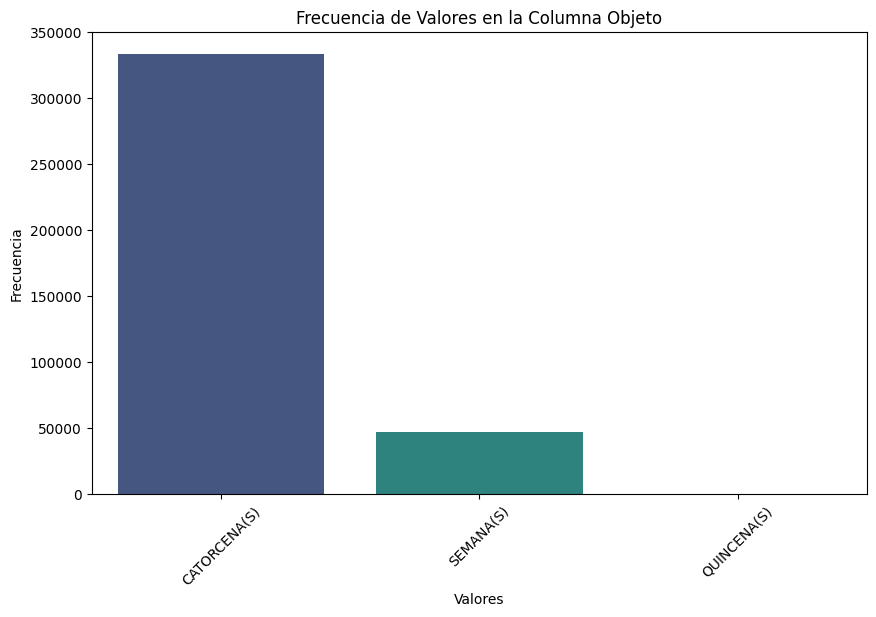

In [12]:
# Calcular la frecuencia de la variable de tipo objeto
frc = newgpdf['PeriodoPago'].value_counts()

# Graficar el resultado
plt.figure(figsize=(10, 6))
sns.barplot(x=frc.index, y=frc.values, palette='viridis')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Valores en la Columna Objeto')
plt.xticks(rotation=45)
plt.show()

In [54]:
# seleccionamos las columnas del nuevo dataframe
columnas = ['IdCliente','NumeroCredito','EdadCliente','CicloCliente','Plazo','EstadoCivil','DAMax','DAMean','EstatusCredito']

# filtramos solo los creditos CATORCENA(S)
newdf = newgpdf[newgpdf['PeriodoPago']=='CATORCENA(S)'][columnas]

# mostramos el valor del nuevo dataframe
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333343 entries, 0 to 380283
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IdCliente       333343 non-null  int64  
 1   NumeroCredito   333343 non-null  int64  
 2   EdadCliente     333343 non-null  int64  
 3   CicloCliente    333343 non-null  int64  
 4   Plazo           333343 non-null  int64  
 5   EstadoCivil     333343 non-null  int64  
 6   DAMax           333343 non-null  float64
 7   DAMean          333343 non-null  float64
 8   EstatusCredito  333343 non-null  object 
dtypes: float64(2), int64(6), object(1)
memory usage: 25.4+ MB


#Baseline

# Avance 4


In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import time

### Preprocesamiento de variables:

Mapeo y división de datos, convertimos la columna "EstatusCredito" en valores numéricos, dondel 'CAI' es '0' y 'CAN' es '1', se divide los datos en conjunto de entrenamiento del 80% y prueba del 20%

In [56]:
# Definir la variable objetivo y las características
newdf['EstatusCredito'] = newdf['EstatusCredito'].map({'CAI': 0, 'CAN': 1})
X = newdf.drop('EstatusCredito', axis=1)  # Todas las columnas excepto 'EstatusCredito' son características independientes
y = newdf['EstatusCredito']  # 'EstatusCredito' es la variable objetivo

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Verificar las dimensiones de los conjuntos de entrenamiento y prueba
print("Dimensiones del conjunto de entrenamiento (X):", X_train.shape)
print("Dimensiones del conjunto de prueba (X):", X_test.shape)
print("Dimensiones del conjunto de entrenamiento (y):", y_train.shape)
print("Dimensiones del conjunto de prueba (y):", y_test.shape)

Dimensiones del conjunto de entrenamiento (X): (266674, 8)
Dimensiones del conjunto de prueba (X): (66669, 8)
Dimensiones del conjunto de entrenamiento (y): (266674,)
Dimensiones del conjunto de prueba (y): (66669,)


### Definición de Pipelines para Transformaciones:

Se aplica una transformación logarítmica y un escalado Min-Max a las columnas númericas, se aplica codifiación One-Hot a las columnas categóricas, se dejan algunas columnas sin transformación y por ultimo se combina todas las transformaciones en un solo tranformador

In [57]:
# Transformaciones que se aplicarán a las variables numéricas usando la clase Pipeline de sklearn:

# Variables numéricas:
num_pipe = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p)),  # Transformación logarítmica
    ('min_max_scaler', MinMaxScaler())  # Escalado Min-Max
])
num_pipe_nombres = ['DAMax', 'DAMean', 'EdadCliente']

# Variables categóricas:
cat_pipe = Pipeline([
    ('one_hot_encoding', OneHotEncoder())  # Codificación One-Hot
])
cat_pipe_nombres = ['CicloCliente', 'Plazo', 'EstadoCivil']


# Variables sin transformar:
no_trans_pipe = 'passthrough'
no_trans_nombres = ['IdCliente', 'NumeroCredito']

# Conjuntemos las transformaciones de todo tipo de variable y en dado caso
# deja inalteradas aquellas que hayas decidido no transformar:

columnasTransformer = ColumnTransformer([
    ('num', num_pipe, num_pipe_nombres),  # Variables numéricas
    ('cat', cat_pipe, cat_pipe_nombres),  # Variables categóricas
    ('notrans', no_trans_pipe, no_trans_nombres)  # Variables sin tranformar
])


Juntamos los conjuntos de entrenamiento y prueba en un solo conjunto para realizar validación cruzada

In [58]:
# Como se va a utilizar Validación-Cruzada, concatena los conjuntos de entrenamiento y validación
# en uno nuevo aumentado que llamaremos trainval para utilizar como entrenamiento:

# Concatenar los conjuntos de entrenamiento y validación
Xtrainval = pd.concat([X_train, X_test], ignore_index=True)
ytrainval = pd.concat([y_train, y_test], ignore_index=True)

# Mostrar las dimensiones del nuevo conjunto trainval
print(Xtrainval.shape, ytrainval.shape)

(333343, 8) (333343,)


Construir al menos 6 modelos diferentes, utilizando algoritmos variados.

In [20]:
def mis_modelos():
  modelos, nombres = list(), list()

  # Regresión Logística:
  modelos.append(LogisticRegression(max_iter=10000, random_state=15, solver='lbfgs'))
  nombres.append('LR')

  # k-Vecinos más Cercanos:
  modelos.append(KNeighborsClassifier(n_neighbors=10, weights='distance'))
  nombres.append('kNN')

  # Árbol de decisiones:
  modelos.append(DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=15))
  nombres.append('DTree')

  # XGBoosting:
  modelos.append(XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=15))
  nombres.append('XGBoost')

  # Red neuronal de Perceptrón Multicapa:
  modelos.append(MLPClassifier(max_iter=10000, hidden_layer_sizes=(100,50), activation='relu', random_state=15))
  nombres.append('MLP')

  # Máquina de Vectores de Soporte:   este modelo es demasiado lento
  #modelos.append(SVC(kernel='rbf', C=1.0, random_state=15))
  #nombres.append('SVM')

  return modelos, nombres

### Evaluación de las métricas durante el proceso de validación cruzada

* Training time: El tiempo total que tomó entrenar el
modelo.
* test_f1 y train_f1: El valor F1, que es la media armónica de la precisión y el recall, tanto en el conjunto de prueba como en el conjunto de entrenamiento.
* test_roc_auc y train_roc_auc: El área bajo la curva ROC, que mide la capacidad del modelo para distinguir entre las clases.
* test_precision y train_precision: La precisión, que es el número de verdaderos positivos dividido por el número de verdaderos positivos más los falsos positivos.
* test_accuracy y train_accuracy: La precisión global del modelo, que es el número de predicciones correctas dividido por el número total de predicciones.
* test_recall y train_recall: El recall, que es el número de verdaderos positivos dividido por el número de verdaderos positivos más los falsos negativos.

In [ ]:
#Entrenemos cada uno de los modelos y desplegamos la métricas de Train y Val.

modelos, nombres = mis_modelos()
resultados = list()

for i in range(len(modelos)):

  # Definimos nuestro pipeline con las transformaciones y los modelos:
  #
  #
  # TODO: ('ct',columnasTransformer),
  pipeline = Pipeline(steps=[('m',modelos[i])])

  # Aplicaremos validación-cruzada:
  micv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

  # Definimos las métricas que desamos recuperar:
  mismetricas = {'accuracy','precision','recall','f1','roc_auc'}

  # Iniciamos timer
  start_time = time.time()

  # Llevamos a cabo el entrenamiento:
  scores = cross_validate(pipeline,
                          Xtrainval,
                          ytrainval,
                          scoring=mismetricas,
                          cv=micv,
                          return_train_score=True,
                          )

  # Detenemos el temporizador
  end_time = time.time()

  # Guardemos el resultado de cada modelopara análisis posteriores.
  resultados.append(scores)

  # Desplegamos los valores de las métricas para verificar si no hay
  # subentrenamiento o sobreentrenamiento:
  print('>> %s' % nombres[i])
  print('\t Training time: %.3f seconds' % (end_time - start_time))
  for j,k in enumerate(list(scores.keys())):
    if j>1:
      print('\t %s %.3f (%.3f)' % (k, np.mean(scores[k]),np.std(scores[k])))

>> LR
	 Training time: 31.736 seconds
	 test_f1 0.984 (0.000)
	 train_f1 0.984 (0.000)
	 test_roc_auc 0.330 (0.007)
	 train_roc_auc 0.330 (0.002)
	 test_precision 0.968 (0.000)
	 train_precision 0.968 (0.000)
	 test_accuracy 0.968 (0.000)
	 train_accuracy 0.968 (0.000)
	 test_recall 1.000 (0.000)
	 train_recall 1.000 (0.000)
>> kNN
	 Training time: 177.452 seconds
	 test_f1 0.992 (0.000)
	 train_f1 1.000 (0.000)
	 test_roc_auc 0.865 (0.005)
	 train_roc_auc 1.000 (0.000)
	 test_precision 0.987 (0.000)
	 train_precision 1.000 (0.000)
	 test_accuracy 0.984 (0.000)
	 train_accuracy 1.000 (0.000)
	 test_recall 0.997 (0.000)
	 train_recall 1.000 (0.000)
>> DTree
	 Training time: 22.957 seconds
	 test_f1 0.998 (0.000)
	 train_f1 0.998 (0.000)
	 test_roc_auc 0.993 (0.001)
	 train_roc_auc 0.994 (0.000)
	 test_precision 0.998 (0.000)
	 train_precision 0.999 (0.000)
	 test_accuracy 0.996 (0.000)
	 train_accuracy 0.996 (0.000)
	 test_recall 0.998 (0.000)
	 train_recall 0.998 (0.000)
>> XGBoost
	 T

### Resultados específicos por modelo:

**Regresión Logística (LR):** La métrica de ROC AUC es extremadamente baja (0.330), lo que indica que el modelo tiene un bajo rendimiento en distinguir entre las clases. La precisión, el recall y la exactitud son altas, pero esto podría deberse a un desequilibrio de clases en el conjunto de datos.

**k-Vecinos más Cercanos (kNN):** Las métricas en el conjunto de entrenamiento son perfectas (1.000), lo que sugiere sobreajuste. Las métricas en el conjunto de prueba también son altas, especialmente el ROC AUC (0.865), lo cual es una buena señal, aunque podría beneficiarse de una mayor generalización.

**Árbol de Decisiones (DTree):** Las métricas son muy altas tanto en el conjunto de entrenamiento como en el de prueba, con un ligero indicio de sobreajuste. El tiempo de entrenamiento es razonablemente corto.

**XGBoost:** Muy buenas métricas tanto en el conjunto de entrenamiento como en el de prueba, pero puede haber un ligero sobreajuste. Buen rendimiento general, con tiempos de entrenamiento aceptables.

**Perceptrón Multicapa (MLP):** El ROC AUC es 0.500, lo cual indica que el modelo no tiene capacidad de discriminación entre clases. Alto tiempo de entrenamiento, pero las métricas de precisión, recall y exactitud son similares a las de la regresión logística, lo cual no justifica el tiempo de entrenamiento.

El modelo de Máquina de Vectores de Soporte (SVM) con el kernel RBF (Radial Basis Function) puede es muy costoso computacionalmente hablando, ya que de las pruebas realizadas no logramos obtener un resultado por mas tiempo de ejecucion que se realizas, hemos llegado a esperar hasta 13 horas y aun asi no arroga los datos del modelo, especialmente con un conjunto de datos grande como el que estamos revisando y con validación cruzada repetida. Esto se deberse a que SVM con kernel RBF tiene una complejidad computacional alta, especialmente con grandes conjuntos de datos. Realizar 5 pliegues con 3 repeticiones significa entrenar el modelo 15 veces para cada métrica. Con más de 300,000 registros, entrenar un SVM puede ser muy lento.

Decidimos cambiar el modelo por el de Random Forest que es nn conjunto de árboles de decisión, que es menos propenso al sobreajuste que los árboles de decisión individuales y generalmente más rápido que SVM para grandes conjuntos de datos.

In [59]:
#import pandas as pd
#import numpy as np
#import time
#from sklearn.pipeline import Pipeline
#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
#from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
#from sklearn.ensemble import RandomForestClassifier

# Supongamos que 'newdf' es el DataFrame que tienes
#newdf = pd.DataFrame()  # Sustituir por el DataFrame real

# Mapear la variable objetivo
#newdf['EstatusCredito'] = newdf['EstatusCredito'].map({'CAI': 0, 'CAN': 1})
#X = newdf.drop('EstatusCredito', axis=1)
#y = newdf['EstatusCredito']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Definir transformaciones para las variables numéricas y categóricas
num_pipe = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p)),
    ('min_max_scaler', MinMaxScaler())
])
num_pipe_nombres = ['DAMax', 'DAMean', 'EdadCliente']

cat_pipe = Pipeline([
    ('one_hot_encoding', OneHotEncoder())
])
cat_pipe_nombres = ['CicloCliente', 'Plazo', 'EstadoCivil']

no_trans_pipe = 'passthrough'
no_trans_nombres = ['IdCliente', 'NumeroCredito']

columnasTransformer = ColumnTransformer([
    ('num', num_pipe, num_pipe_nombres),
    ('cat', cat_pipe, cat_pipe_nombres),
    ('notrans', no_trans_pipe, no_trans_nombres)
])

# Concatenar los conjuntos de entrenamiento y prueba
Xtrainval = pd.concat([X_train, X_test], ignore_index=True)
ytrainval = pd.concat([y_train, y_test], ignore_index=True)


In [60]:
print(newdf['EstatusCredito'].isna().sum())

0


In [61]:

# Definir el modelo Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=15)

# Crear el pipeline con las transformaciones y el modelo
pipeline = Pipeline(steps=[
    ('ct', columnasTransformer),
    ('m', random_forest_model)
])

# Aplicar validación cruzada
micv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
mismetricas = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Iniciar el temporizador
start_time = time.time()

# Entrenar el modelo y obtener las métricas
scores = cross_validate(pipeline, Xtrainval, ytrainval, scoring=mismetricas, cv=micv, return_train_score=True)

# Detener el temporizador
end_time = time.time()

# Guardar y mostrar los resultados
print('>> Random Forest')
print('\t Training time: %.3f seconds' % (end_time - start_time))
for j, k in enumerate(list(scores.keys())):
    if j > 1:
        print('\t %s %.3f (%.3f)' % (k, np.mean(scores[k]), np.std(scores[k])))


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.10/di

>> Random Forest
	 Training time: 1998.759 seconds
	 test_f1 nan (nan)
	 train_f1 1.000 (0.000)
	 test_recall nan (nan)
	 train_recall 1.000 (0.000)
	 test_accuracy nan (nan)
	 train_accuracy 1.000 (0.000)
	 test_roc_auc nan (nan)
	 train_roc_auc 1.000 (0.000)
	 test_precision nan (nan)
	 train_precision 1.000 (0.000)


El resultado obtenido del modelo Random Forest muestra varios problemas que necesitan ser abordados comenzando por el tiempo de entrenamiento es bastante largo, lo que indica que el modelo Random Forest tardó considerablemente en ajustarse a los datos.  El F1-score de entrenamiento es perfecto (1.000) con una desviación estándar de 0.000, lo que indica que el modelo está perfectamente ajustado en el conjunto de entrenamiento.

Tanto el recall como la precisión de entrenamiento son perfectos, sugiriendo que el modelo clasifica todas las instancias correctamente en el conjunto de entrenamiento. La precisión y el AUC-ROC de entrenamiento también son perfectos, reforzando la idea de que el modelo está perfectamente ajustado en el conjunto de entrenamiento. Los valores de las métricas en el conjunto de prueba son nan (not a number), lo que sugiere que el modelo no pudo calcular estas métricas en el conjunto de prueba.

El modelo Random Forest parece estar sobreajustado al conjunto de entrenamiento, ya que todas las métricas son perfectas en el entrenamiento pero no se pueden calcular en el conjunto de prueba. Esto suele ocurrir cuando el modelo es demasiado complejo y se ajusta a los ruidos específicos del conjunto de entrenamiento. Los valores nan en las métricas de prueba sugieren que podría haber algún problema con los datos del conjunto de prueba. Es posible que haya valores faltantes, datos mal formateados o un desequilibrio extremo en las clases.

### Ajuste de Hiperparámetros

RandomizedSearchCV permite buscar sobre un espacio de hiperparámetros utilizando una estrategia de muestreo aleatorio, lo cual puede ser más eficiente que GridSearchCV en términos de tiempo de computación.

Definimos los espacios de búsqueda de hiperparametros para cada uno de los modelos. Ajustamos a cada modelo utilizando RandomizedSearchCV dentro del bucle de entrenamiento

* param_grid: Define el espacio de búsqueda de hiperparámetros para cada modelo. Por ejemplo, para la regresión logística, se varían C y solver.
* RandomizedSearchCV: Configura la búsqueda aleatoria sobre el espacio de hiperparámetros definido. n_iter=50 especifica que se harán 50 combinaciones aleatorias de hiperparámetros.
* random_search.fit(Xtrainval, ytrainval): Ajusta el modelo utilizando RandomizedSearchCV.
* random_search.best_estimator_: Obtiene el mejor estimador (modelo con los mejores hiperparámetros).
* random_search.best_score_: Muestra la mejor puntuación obtenida durante la búsqueda.
* random_search.best_params_: Muestra los mejores parámetros encontrados durante la búsqueda.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Espacios de búsqueda de hiperparámetros
param_grid = {
    'LR': {
        'm__C': uniform(0.01, 10),
        'm__solver': ['newton-cg', 'lbfgs', 'liblinear']
    },
    'kNN': {
        'm__n_neighbors': randint(1, 30),
        'm__weights': ['uniform', 'distance']
    },
    'DTree': {
        'm__max_depth': randint(1, 20),
        'm__criterion': ['gini', 'entropy']
    },
    'XGBoost': {
        'm__n_estimators': randint(50, 200),
        'm__learning_rate': uniform(0.01, 0.3),
        'm__max_depth': randint(3, 10)
    },
    'MLP': {
        'm__hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'm__activation': ['tanh', 'relu'],
        'm__learning_rate_init': uniform(0.001, 0.1)
    },
    'RF': {
        'm__n_estimators': randint(50, 200),
        'm__max_depth': randint(5, 20),
        'm__criterion': ['gini', 'entropy']
    }
}

In [ ]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import time

# Definición de la función de modelos
def mis_modelos_3():
    modelos3, nombres = list(), list()

    # Regresión Logística
    modelos3.append(LogisticRegression(max_iter=10000, random_state=15))
    nombres.append('LR')

    # k-Vecinos más Cercanos
    modelos3.append(KNeighborsClassifier())
    nombres.append('kNN')

    # Árbol de decisiones
    modelos3.append(DecisionTreeClassifier(random_state=15))
    nombres.append('DTree')

    # XGBoosting
    modelos3.append(XGBClassifier(random_state=15))
    nombres.append('XGBoost')

    # Red neuronal de Perceptrón Multicapa
    modelos3.append(MLPClassifier(max_iter=10000, random_state=15))
    nombres.append('MLP')

    # Random Forest
    modelos3.append(RandomForestClassifier(random_state=15))
    nombres.append('RF')

    return modelos3, nombres


In [ ]:

modelos3, nombres = mis_modelos_3()
resultados = list()

# Concatenar los conjuntos de entrenamiento y validación
Xtrainval = pd.concat([X_train, X_test], ignore_index=True)
ytrainval = pd.concat([y_train, y_test], ignore_index=True)

# Transformador de columnas
columnasTransformer = ColumnTransformer([
    ('num', num_pipe, num_pipe_nombres),  # Variables numéricas
    ('cat', cat_pipe, cat_pipe_nombres),  # Variables categóricas
    ('notrans', no_trans_pipe, no_trans_nombres)  # Variables sin tranformar
])

for i in range(len(modelos3)):
    # Definimos nuestro pipeline con las transformaciones y los modelos:
    pipeline = Pipeline(steps=[('ct', columnasTransformer), ('m', modelos3[i])])

    # Definir los parámetros de búsqueda para cada modelo
    param_dist = param_grid[nombres[i]]

    # Configuración de RandomizedSearchCV
    random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=50, scoring='accuracy', n_jobs=-1, cv=5, random_state=42)

    # Iniciamos timer
    start_time = time.time()

    # Llevamos a cabo el ajuste del modelo
    random_search.fit(Xtrainval, ytrainval)

    # Detenemos el temporizador
    end_time = time.time()

    # Guardemos el resultado del modelo para análisis posteriores.
    resultados.append(random_search.best_estimator_)

    # Desplegamos los valores de las métricas para verificar si no hay subentrenamiento o sobreentrenamiento:
    print('>> %s' % nombres[i])
    print('\t Training time: %.3f seconds' % (end_time - start_time))
    print('\t Best Score: %.3f' % random_search.best_score_)
    print('\t Best Params: %s' % random_search.best_params_)


In [ ]:
def plot_metric_scores(metric_scores, metric_name, color_palette):
    df = pd.DataFrame(metric_scores)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, palette=color_palette)
    plt.title(f'{metric_name} Scores de los Modelos')
    plt.ylabel(metric_name)
    plt.xlabel('Modelos')
    plt.xticks(rotation=45)
    plt.show()

# Recolectar recall y plotear
recall_scores = {nombres[i]: resultados[i]['test_recall'] for i in range(len(modelos))}
plot_metric_scores(recall_scores, 'Recall', 'Blues')

# Recolectar F1-score y plotear
f1_scores = {nombres[i]: resultados[i]['test_f1'] for i in range(len(modelos))}
plot_metric_scores(f1_scores, 'F1 Score', 'Reds')


NameError: name 'modelos' is not defined

Seleccionar los dos modelos que proporcionen el mejor rendimiento.

In [ ]:
#SMOTE para clases no balanceadas
from imblearn.over_sampling import SMOTE

In [ ]:
def mis_modelos2():
    modelos, nombres = list(), list()

    # Regresión Logística:
    modelos.append(LogisticRegression(max_iter=10000, random_state=15, solver='lbfgs'))
    nombres.append('LR')

    # Árbol de decisiones:
    modelos.append(DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=15))
    nombres.append('DTree')
    return modelos, nombres

In [ ]:
modelos, nombres = mis_modelos2()
resultados = list()
sampling_strategy = 0.75

for i in range(len(modelos)):
    # Definimos nuestro pipeline con las transformaciones y los modelos:
    pipeline = Pipeline(steps=[('sampling', SMOTE(sampling_strategy=sampling_strategy)),
                                #('ct', columnasTransformer),
                                ('m', modelos[i])])

    # Aplicaremos validación-cruzada:
    micv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

    # Definimos las métricas que deseamos recuperar:
    mismetricas = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

    # Iniciamos timer
    start_time = time.time()

    # Llevamos a cabo el entrenamiento:
    scores = cross_validate(pipeline,
                            Xtrainval,
                            ytrainval,
                            scoring=mismetricas,
                            cv=micv,
                            return_train_score=True)

    # Detenemos el temporizador
    end_time = time.time()

    # Guardamos el resultado de cada modelo para análisis posteriores.
    resultados.append(scores)

    # Desplegamos los valores de las métricas para verificar si no hay
    # subentrenamiento o sobreentrenamiento:
    print('>> %s' % nombres[i])
    print('\t Training time: %.3f seconds' % (end_time - start_time))
    for j, k in enumerate(list(scores.keys())):
        if j > 1:
            print('\t %s %.3f (%.3f)' % (k, np.mean(scores[k]), np.std(scores[k])))

Ajustar los dos mejores modelos.

In [ ]:
# Con dicho mejor modelo y utilizando la técnica de validación cruzada, busca
# los mejores hiperparámetros de dicho modelo
from sklearn.model_selection import GridSearchCV

# Definimos el Pipeline con SMOTE, transformaciones y Regresión Logística
pipeline = Pipeline([
    ('balanceo', SMOTE(sampling_strategy=0.75)),
    #('transformaciones', columnasTransformer),
    ('regresion_logistica', LogisticRegression(max_iter=10000, random_state=15))
])

# Definimos el espacio de búsqueda para GridSearchCV
parametros_grid = {
    'regresion_logistica__penalty': ['l2'],
    'regresion_logistica__C': [0.001, 0.01, 0.1, 1, 10],
    'regresion_logistica__solver': ['liblinear', 'saga', 'lbfgs']
}

# Utilizamos GridSearchCV para buscar hiperparámetros óptimos
busqueda_grid = GridSearchCV(estimator=pipeline, param_grid=parametros_grid, scoring='f1', cv=5)
busqueda_grid.fit(Xtrainval, ytrainval)

print("Mejores hiperparámetros:")
print(busqueda_grid.best_params_)

# Seleccionamos el mejor modelo encontrado por GridSearchCV
mejor_modelo = busqueda_grid.best_estimator_

# Aplicamos Validación-Cruzada y mostramos los resultados
micv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
mismetricas = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}
resultados_validacion = cross_validate(mejor_modelo, Xtrainval, ytrainval, scoring=mismetricas, cv=micv, return_train_score=True)

print('Resultados de validación cruzada:')
for metrica in mismetricas:
    print(f"{metrica.capitalize()} promedio:", np.mean(resultados_validacion[f"test_{metrica}"]),
          f"({np.std(resultados_validacion[f'test_{metrica}']):.3f})")


Elegir el modelo individual final.

In [ ]:
#### TODO

In [ ]:
# el mejor modelo y los mejores hiperparámetros encontrados en el ejercicio anterior,
# utiliza ahora (por primera vez en la actividad) el conjunto de prueba (test set) para:

y_pred_test = mejor_modelo.predict(Xtest)

print("Métricas en el conjunto de prueba:")
print(classification_report(ytest, y_pred_test))


In [ ]:
# b.	Obtener la matriz de confusión.

from sklearn.metrics import confusion_matrix

# Realizar predicciones en el conjunto de prueba
y_pred_test = mejor_modelo.predict(Xtest)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(ytest, y_pred_test)

# Mostrar la matriz de confusión
print("Matriz de confusión en el conjunto de prueba:")
print(conf_matrix)


NameError: name 'mejor_modelo' is not defined